In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/ann/220116_annkw.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-16 01:00:00,#annkw
1,2022-01-16 01:00:00,#annkw
2,2022-01-16 01:00:00,#annkw
3,2022-01-16 01:00:00,ニチレイプレゼンツ！！ #annkw
4,2022-01-16 01:00:00,#annkw
...,...,...
10449,2022-01-16 03:04:15,若さんが禁煙を始めてくれたならば、しっかりとコレを見守り折に触れチェックを促さないと…！ ...
10450,2022-01-16 03:04:15,死んやめがなかったのは今週は仕方ないな #annkw #jolf
10451,2022-01-16 03:04:41,動画までツイートしてくれるの珍しい ありがてえ… #annkw
10452,2022-01-16 03:04:52,ミッフィーちゃん 夢股ディオス #annkw


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-16 01:00:00,
1,2022-01-16 01:00:00,
2,2022-01-16 01:00:00,
3,2022-01-16 01:00:00,ニチレイプレゼンツ
4,2022-01-16 01:00:00,
...,...,...
10449,2022-01-16 03:04:15,若さんが禁煙を始めてくれたならばっかりとコレを見守り折に触れチェックを促さないとくらいの気持...
10450,2022-01-16 03:04:15,死んやめがなかったのは今週は仕方ないな
10451,2022-01-16 03:04:41,動画までツイートてくれるの珍いありがてえ
10452,2022-01-16 03:04:52,ミッフィーちゃん夢股ディオス


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-16 01:00:00,,0
1,2022-01-16 01:00:00,,0
2,2022-01-16 01:00:00,,0
3,2022-01-16 01:00:00,ニチレイプレゼンツ,[ニチレイプレゼンツ]
4,2022-01-16 01:00:00,,0
...,...,...,...
10449,2022-01-16 03:04:15,若さんが禁煙を始めてくれたならばっかりとコレを見守り折に触れチェックを促さないとくらいの気持...,"[若さ, ん, 禁煙, 始め, くれ, コレ, 見守り, 折, 触れ, チェック, 促さ, ..."
10450,2022-01-16 03:04:15,死んやめがなかったのは今週は仕方ないな,"[死ん, やめ, なかっ, の, 今週, 仕方]"
10451,2022-01-16 03:04:41,動画までツイートてくれるの珍いありがてえ,"[動画, ツイート, くれる, の, 珍い, あり]"
10452,2022-01-16 03:04:52,ミッフィーちゃん夢股ディオス,"[ミッフィー, ちゃん, 夢, 股, ディオス]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-16 01:00:00,"[ニチレイプレゼンツ, ひとつ, なに, ひと, オードリーのオールナイトニッポン, ニッポ..."
1,2022-01-16 01:01:00,"[今夜, カスミン, っ, 若様, 津波情報, オードリーのオールナイトニッポン, 時間, ..."
2,2022-01-16 01:02:00,"[津波情報, 放送, 聞き, の, 山, 津波, ょうがないね, 津波情報, 津波情報, ほ..."
3,2022-01-16 01:03:00,"[ひろ, アナウンサー, まだ, 津波, 上昇, 中, 遠方, 地震, 由来, ピーク, 長..."
4,2022-01-16 01:04:00,"[ひろ, アナウンサー, 改めて, ひとつ, なに, 土曜, 夜, カスミン, ひとつ, な..."
...,...,...
120,2022-01-16 03:00:00,"[ミッフィー, ちゃん, チャレンジ, 成功, イレギュラー, 中, ボリューム, ある, ..."
121,2022-01-16 03:01:00,"[ミッフィー, ちゃん, アディオス, エンディング, やら, 0分, 間, 警報, アナウ..."
122,2022-01-16 03:02:00,"[すげ, ー, 写真, 竹野内豊, 春日, 父, 見える, 0, ショット, ミッフィー, ..."
123,2022-01-16 03:03:00,"[逆, 貧, めちゃくちゃ, おもろかっ, wwwwww, 最高, wwwwww, 津波情報..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
120    None
121    None
122    None
123    None
124    None
Length: 125, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-16 01:00:00,0
1,2022-01-16 01:00:00,0
2,2022-01-16 01:00:00,0
3,2022-01-16 01:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-01-16 01:00:00,0
...,...,...
10449,2022-01-16 03:04:15,"[0.23212613, -0.046886757, -0.9759568, -0.6270..."
10450,2022-01-16 03:04:15,"[0.5018812, 1.0105697, -1.459313, -0.114338934..."
10451,2022-01-16 03:04:41,"[-0.3727609, 0.64623064, -2.07416, -2.2323246,..."
10452,2022-01-16 03:04:52,"[-0.060696073, -0.68180215, 0.233145, -0.55103..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-16 01:00:00,"[0, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-01-16 01:01:00,"[0, 0, [0.3429518, 0.13191879, 1.1616061, -0.1..."
2,2022-01-16 01:02:00,"[0, [0.046941906, 0.096384875, 0.018229883, -0..."
3,2022-01-16 01:03:00,"[0, 0, [0.25454235, 0.16202694, 0.46875274, -6..."
4,2022-01-16 01:04:00,"[[0.25454235, 0.16202694, 0.46875274, -6.47306..."
...,...,...
120,2022-01-16 03:00:00,"[[-0.31232888, -0.18915421, -0.13026473, -0.35..."
121,2022-01-16 03:01:00,"[[-0.24068533, -0.15898047, 0.6223481, -0.0171..."
122,2022-01-16 03:02:00,"[[-0.36362872, -0.28735864, -0.77440053, -0.49..."
123,2022-01-16 03:03:00,"[[-0.57027024, 0.014300744, -0.44559935, -0.99..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-16 01:00:00,-0.001721,0.146323,0.367954,0.232572,0.310463
1,2022-01-16 01:01:00,0.026843,0.158241,0.362084,0.227875,0.282683
2,2022-01-16 01:02:00,0.059698,0.190733,0.338267,0.215870,0.215473
3,2022-01-16 01:03:00,0.073847,0.245575,0.591294,0.346069,0.337997
4,2022-01-16 01:04:00,0.116442,0.244420,0.416222,0.344632,0.323019
...,...,...,...,...,...,...
120,2022-01-16 03:00:00,0.260046,0.438113,0.647618,0.463280,0.289461
121,2022-01-16 03:01:00,0.244059,0.377045,0.583705,0.426559,0.280921
122,2022-01-16 03:02:00,0.147569,0.335318,0.476000,0.330426,0.231651
123,2022-01-16 03:03:00,0.169168,0.363922,0.523826,0.349090,0.219683


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220116_ann/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,-0.001721,0.146323,0.367954,0.232572,0.310463,799
1,2,0.026843,0.158241,0.362084,0.227875,0.282683,277
2,3,0.059698,0.190733,0.338267,0.215870,0.215473,110
3,4,0.073847,0.245575,0.591294,0.346069,0.337997,199
4,5,0.116442,0.244420,0.416222,0.344632,0.323019,213
...,...,...,...,...,...,...,...
120,121,0.260046,0.438113,0.647618,0.463280,0.289461,64
121,122,0.244059,0.377045,0.583705,0.426559,0.280921,33
122,123,0.147569,0.335318,0.476000,0.330426,0.231651,21
123,124,0.169168,0.363922,0.523826,0.349090,0.219683,15


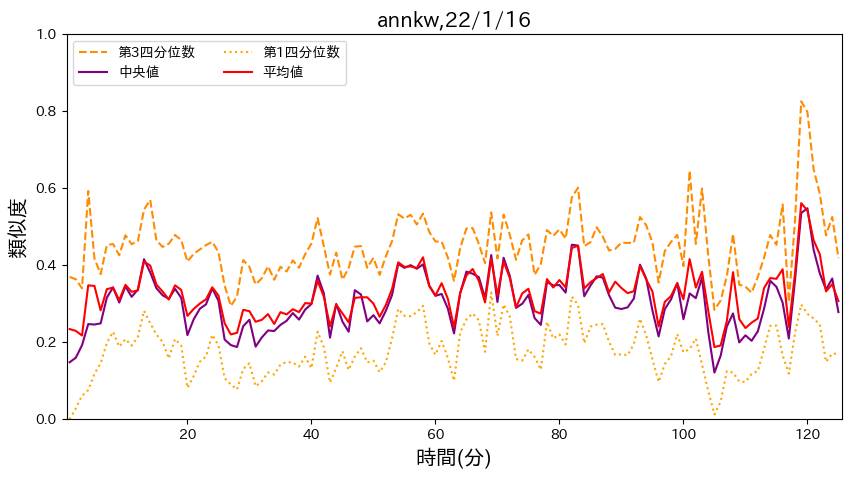

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/16", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


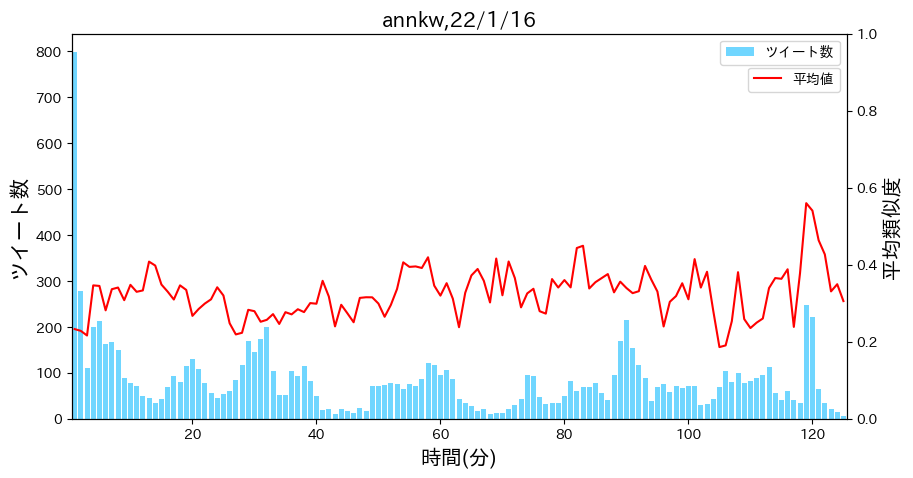

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/16", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


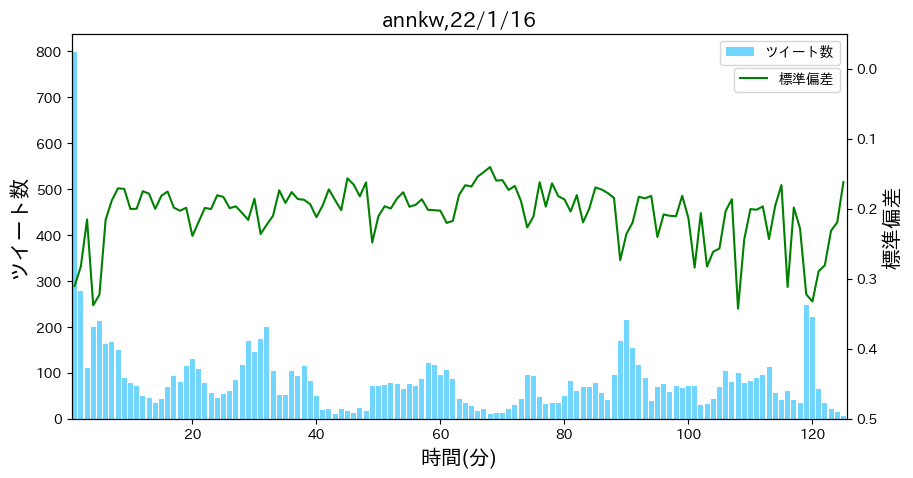

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "annkw,22/1/16", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
